In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('Clase_04_temperatura_transf.csv')
data

,fecha,Tmax,Tmin,Tmean
0,1959-01-04,26.125000,15.850000,20.987500
1,1959-01-11,26.600000,12.785714,19.692857
2,1959-01-18,28.300000,16.885714,22.592857
3,1959-01-25,31.300000,16.400000,23.850000
4,1959-02-01,27.633333,16.014286,21.823810
...,...,...,...,...
3098,2018-05-20,17.857143,10.242857,14.050000
3099,2018-05-27,20.500000,10.085714,15.292857
3100,2018-06-03,18.071429,11.014286,14.542857
3101,2018-06-10,15.614286,8.257143,11.935714


<Axes: xlabel='fecha', ylabel='Tmean'>

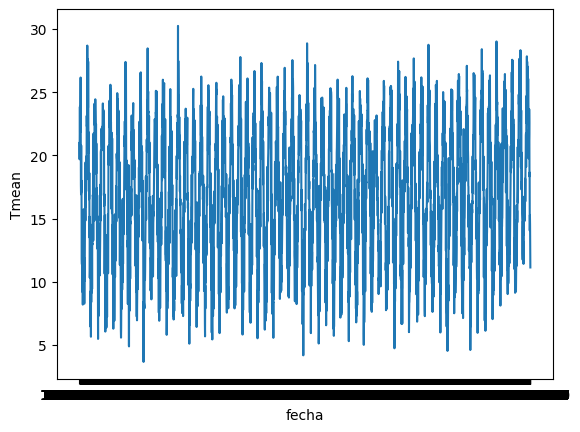

In [ ]:
sns.lineplot(x = data['fecha'], y = data['Tmean'])



In [ ]:
data = data.sort_values(by = ['fecha'])
data['fecha'] = pd.to_datetime(data['fecha'], format='%Y-%m-%d')
train = data[(data['fecha']>= '2000-01-01') & (data['fecha']<='2016-12-31')]
test = data[(data['fecha']>='2017-01-01')]

In [ ]:
train_array = train.set_index('fecha')['Tmean']
test_array = test.set_index('fecha')['Tmean']

In [ ]:
train_array

fecha
2000-01-02    24.635714
2000-01-09    25.442857
2000-01-16    25.421429
2000-01-23    24.778571
2000-01-30    25.500000
                ...    
2016-11-27    21.542857
2016-12-04    24.814286
2016-12-11    24.042857
2016-12-18    24.378571
2016-12-25    25.464286
Name: Tmean, Length: 887, dtype: float64

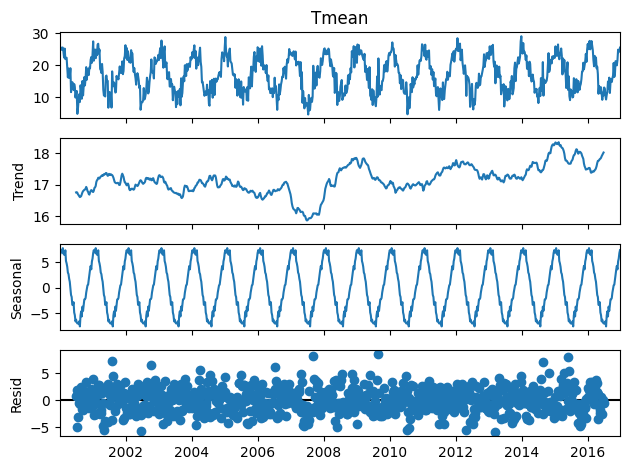

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
series = train_array
result = seasonal_decompose(series, model='additive')
result.plot()
plt.show()

In [ ]:
### Test de Dicky-Fuller augmented

from statsmodels.tsa.stattools import adfuller

adfuller(series)

(-12.76438471646511,
 8.015853615824232e-24,
 21,
 865,
 {'1%': -3.4379324415517494,
  '5%': -2.864887107873992,
  '10%': -2.568552251328143},
 3958.5214763696235)

In [ ]:
### Si no son estacionarios, generar diferencias
train['Tmean'] - train['Tmean'].shift(1)

2139         NaN
2140    0.807143
2141   -0.021429
2142   -0.642857
2143    0.721429
          ...   
3021    1.621429
3022    3.271429
3023   -0.771429
3024    0.335714
3025    1.085714
Name: Tmean, Length: 887, dtype: float64

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
modelo = ARIMA(train_array, order=(2, 0, 3), seasonal_order=(0,0,0,52))
res = modelo.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  Tmean   No. Observations:                  887
Model:                 ARIMA(2, 0, 3)   Log Likelihood               -1979.858
Date:                Sat, 18 Nov 2023   AIC                           3973.716
Time:                        00:20:31   BIC                           4007.231
Sample:                    01-02-2000   HQIC                          3986.528
                         - 12-25-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.1825      0.091    189.097      0.000      17.004      17.361
ar.L1          1.9855   3.05e-05   6.52e+04      0.000       1.985       1.986
ar.L2         -1.0000   1.52e-05  -6.57e+04      0.0

In [ ]:
inicio = train_array.shape[0]
test_size = test_array.shape[0]
preds = res.predict(inicio, inicio + test_size-1)
preds

2017-01-01    24.100588
2017-01-08    23.995874
2017-01-15    24.074389
2017-01-22    24.052935
2017-01-29    23.931824
                ...    
2018-05-20    13.594162
2018-05-27    12.912345
2018-06-03    12.292470
2018-06-10    11.743529
2018-06-17    11.273484
Freq: W-SUN, Name: predicted_mean, Length: 77, dtype: float64

In [ ]:
from sklearn.metrics import mean_absolute_error

mae_arima = mean_absolute_error(preds, test_array)
print(mae_arima)

2.325694003939944


<Axes: xlabel='fecha'>

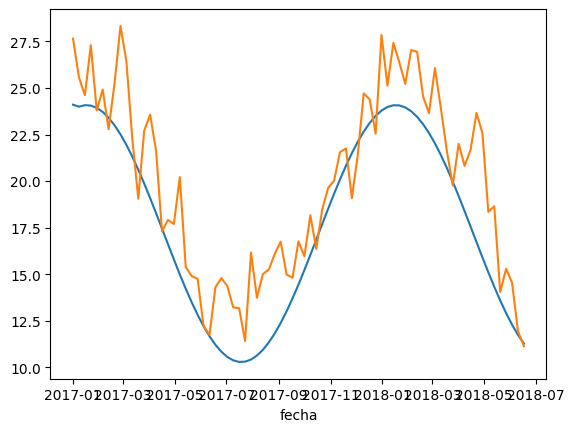

In [ ]:
sns.lineplot(x = preds.index, y = preds.values)
sns.lineplot(x = test_array.index, y = test_array.values)

In [ ]:
### Autoarima
!pip install pmdarima
from pmdarima.arima import auto_arima


In [ ]:
autoarima = auto_arima(train_array)

In [ ]:
autoarima

ARIMA(order=(2, 0, 3), scoring_args={}, suppress_warnings=True)

In [ ]:
### Redes neuronales LSTM

from sklearn.preprocessing import StandardScaler

def create_dataset(x,y,time_step = 1):
  xs = []
  ys = []
  for i in range(len(x) - time_step):
    v = x.iloc[i:(i+time_step)].values
    xs.append(v)
    ys.append(y.iloc[i+time_step])

  return np.array(xs), np.array(ys)


esc = StandardScaler()
train_esc = pd.DataFrame(esc.fit_transform(train_array.values.reshape(-1, 1)), columns = ['temperature'])
test_esc = pd.DataFrame(esc.transform(test_array.values.reshape(-1, 1)), columns = ['temperature'])

In [ ]:
time_lag = 1
x_train, y_train = create_dataset(train_esc, train_esc.temperature, time_lag)
x_test, y_test = create_dataset(test_esc, test_esc.temperature, time_lag)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import backend as K

K.clear_session()

model = Sequential()
model.add(LSTM(units = 128, return_sequences = True, input_shape = (x_train.shape[1], x_train.shape[2])))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(rate = 0.05))
model.add(LSTM(units = 250, return_sequences = True))
model.add(LSTM(units = 250, return_sequences = True))
model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(rate = 0.01))
model.add(Dense(units = 1))
model.compile(optimizer =  'adam', loss = 'mean_squared_error')
history = model.fit(x_train, y_train, epochs = 60, shuffle = False, batch_size = 32)


Epoch 1/60
28/28 [==============================] - 19s 21ms/step - loss: 0.9985
Epoch 2/60
28/28 [==============================] - 1s 18ms/step - loss: 0.9641
Epoch 3/60
28/28 [==============================] - 0s 17ms/step - loss: 0.9611
Epoch 4/60
28/28 [==============================] - 1s 18ms/step - loss: 0.9602
Epoch 5/60
28/28 [==============================] - 0s 16ms/step - loss: 0.9594
Epoch 6/60
28/28 [==============================] - 1s 19ms/step - loss: 0.9590
Epoch 7/60
28/28 [==============================] - 0s 18ms/step - loss: 0.9593
Epoch 8/60
28/28 [==============================] - 1s 19ms/step - loss: 0.9588
Epoch 9/60
28/28 [==============================] - 0s 18ms/step - loss: 0.9588
Epoch 10/60
28/28 [==============================] - 0s 17ms/step - loss: 0.9589
Epoch 11/60
28/28 [==============================] - 0s 15ms/step - loss: 0.9586
Epoch 12/60
28/28 [==============================] - 0s 16ms/step - loss: 0.9585
Epoch 13/60
28/28 [=================

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            66560     
                                                                 
 lstm_1 (LSTM)               (None, 1, 128)            131584    
                                                                 
 dropout (Dropout)           (None, 1, 128)            0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 250)            379000    
                                                                 
 lstm_3 (LSTM)               (None, 1, 250)            501000    
                                                                 
 lstm_4 (LSTM)               (None, 1, 100)            140400    
                                                                 
 dropout_1 (Dropout)         (None, 1, 100)            0

In [ ]:
preds_lstm = model.predict(x_test)

3/3 [==============================] - 2s 7ms/step


In [ ]:
preds_lstm_inv = esc.inverse_transform(preds_lstm[:,0][:])

In [ ]:
preds_lstm_inv.shape

(76, 1)

<Axes: xlabel='fecha'>

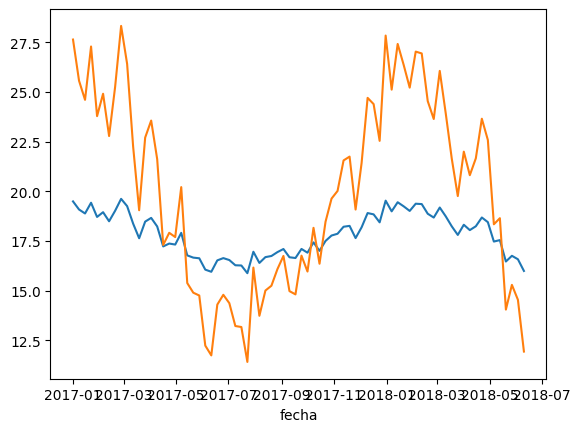

In [ ]:
sns.lineplot(x = test_array.index[:76], y = preds_lstm_inv[:,0])
sns.lineplot(x = test_array.index[:76], y = test_array.values[:76])

In [ ]:
mae_lstm = mean_absolute_error(preds_lstm_inv, test_array[:76])
mae_lstm

3.586659241798229